## RNN & LSTM 及其实践

- ok，我们来看一下rnn的结构
<br/>
<img src="https://raw.githubusercontent.com/nanyoullm/nanyoullm.github.io/master/img/rnn.png" width="150" height="200" alt="rnn"/>
<br/>
- t时刻的输入$x_{t}$进入神经网络A后，一方面会输出一个结果$h_{t}$，同时会输出一个状态传递到下一次的循环中，作为下一次循环的自产的输入。在这个循环的过程中，A里的参数都是共享的。那么，把rnn的循环过程展开后是什么样子的呢？如下图所示：
<br/>
<img
src="https://upload-images.jianshu.io/upload_images/42741-d6749df8fb93b0b0.png?imageMogr2/auto-orient/" alt="rnn-flatten"/>
<br/>

- 这个结构使得它对时序性的变量有着先天性的优势，在语音识别等领域取得了一定成功。但是这个结构也存在一定的缺陷，我们来看看，以下文字摘自[lstm简介](https://www.jianshu.com/p/9dc9f41f0b29)
> 假设我们试着去预测“I grew up in France... I speak fluent French”最后的词。当前的信息建议下一个词可能是一种语言的名字，但是如果我们需要弄清楚是什么语言，我们是需要先前提到的离当前位置很远的 France 的上下文的。这说明相关信息和当前预测位置之间的间隔就肯定变得相当的大。
不幸的是，在这个间隔不断增大时，RNN 会丧失学习到连接如此远的信息的能力。

- 也就是说，RNN在处理***长期依赖***问题上是具有一定的缺陷。

- 我们尝试用rnn做一个简单的回归预测，例子取自与莫凡大神的教程[莫凡python](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-03-RNN-regression/)
- 输入数据为一个sin函数，对应的预测值为cos函数；也就是用构造一个sin到cos的映射神经网络；所以，这是一个用rnn来训练sin对cos的函数映射的**回归预测**问题。

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

- 我们先看一哈sin和cos在xy坐标下的曲线
- 总步长数为100，每一步的长度为$\frac{2\pi}{100}$

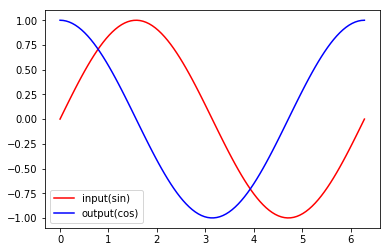

In [2]:
steps = np.linspace(0, np.pi * 2, 100, dtype=np.float32)

x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, x_np, 'r-', label='input(sin)')
plt.plot(steps, y_np, 'b-', label='output(cos)')
plt.legend(loc='best')
plt.show()

- ok，现在我们来构建一下rnn网络
- 注意，这是一个 ***sequence2sequence*** 回归的预测，rnn的每一次循环的输出结果都是我们需要拿出来和y值计算loss的，我们可以通过forward函数里看到。

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size = 32,
            num_layers = 1,
            batch_first = True
        )
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x, h_state):
        # 我们需要上一轮循环的h_state
        # 所以输入的参数为x和前一个循环的h_state
        r_out, h_state = self.rnn(x, h_state)
        outs = []
        # 按序列取出这一轮循环的每一个step的输出
        for time_step in range(r_out.size(1)):
            outs.append(self.fc(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

- 在xy坐标轴上，sin作为一个时序的数据，x是时序步长，y为x在每个步长上的feature值，所以feature的维度为1（即input_size），我们设定总步长数为10，每一步的长度为$\frac{2\pi}{10}$，学习率为0.01

In [4]:
time_step = 10
input_size = 1
learning_rate = 0.01
rnn = RNN().cuda()

In [5]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# 最初始的h_state设为None
h_state = None

In [6]:
plt.figure(1, figsize=(12, 5))
plt.ion()

In [7]:
for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi
    steps = np.linspace(start, end, time_step, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    
    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).cuda()
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis])).cuda()
    
    prediction, h_state = rnn(x, h_state)
    h_state = Variable(h_state.data)
    
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.05)

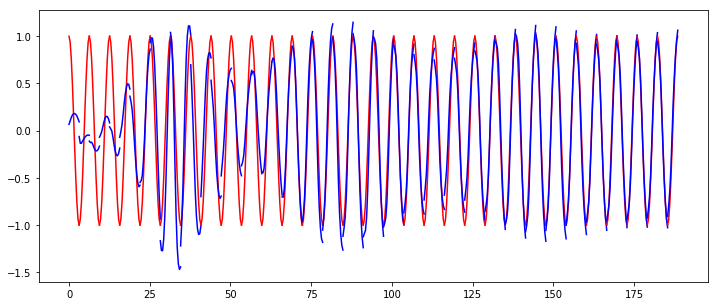

In [8]:
plt.ioff()
plt.show()

- 上图中，红色的曲线为用于训练数据，蓝色的曲线是预测数据，可以明显看到预测的数据有“断崖”的情况。

- 上面说到，RNN在处理***长期依赖***问题上是具有一定的缺陷，而lstm可以解决这个问题，我们看一下lstm的初貌：
<br/>
<img
src="https://raw.githubusercontent.com/nanyoullm/nanyoullm.github.io/master/img/lstm1.png" alt="lstm"/>
<br/>
- 相比与rnn中A（我们可以称之为cell或unit）内部的简单网络结构，lstm的内部结构较为复杂，同时增加了一个关键的***细胞状态***
- cell内部的结构由四个门构成：
    1. input_gate
    2. forget_gate
    3. cell_state(gate)
    4. output_gate
- 具体每个门的公式可以参考[lstm简介](https://www.jianshu.com/p/9dc9f41f0b29)

- ok，我们再来看一下lstm的预测效果，参数上来看lstm比rnn在每次的迭代需要多传送cell state参数

In [9]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x, h, c):
        r_out, _ = self.lstm(x, (h, c))
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.fc(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), _

In [10]:
rnn = LSTM().cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# 设定h_state 和 c_state的初始值
h = Variable(torch.zeros(1, 1, 32).cuda())
c = Variable(torch.zeros(1, 1, 32).cuda())

In [11]:
for step in range(60):
    start, end = step * np.pi, (step + 1) * np.pi
    steps = np.linspace(start, end, time_step, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis])).cuda()
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis])).cuda()

    prediction, (h, c) = rnn(x, h, c)
    h = Variable(h.data)
    c = Variable(c.data)

    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.05)

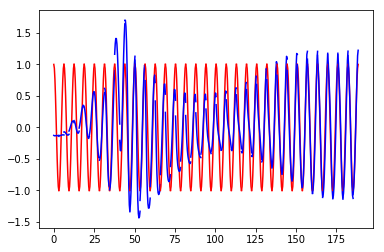

In [12]:
plt.ioff()
plt.show()

- 同样，红色的是训练数据，蓝色的是预测数据；
- 可以看出来lstm的预测结果在形状上没有单纯rnn的断崖情况，而且随着训练数据的增加趋于稳定。

## enjoy it!